In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
%matplotlib inline
plt.style.use('default')
sns.set()

#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})

## Los usuarios que hicieron checkout. ¿Concretaron la conversión?

In [9]:
checkouts = df.loc[df['event'] == 'checkout',["sku","timestamp","person","model","condition","storage","color"]]
conversiones = df.loc[df['event'] == 'conversion',["sku","timestamp","person","model","condition","storage","color"]]

### Observemos la evolución de los checkouts en el tiempo

[Text(0,0.5,'Cantidad semanal'), Text(0.5,0,'Fecha')]

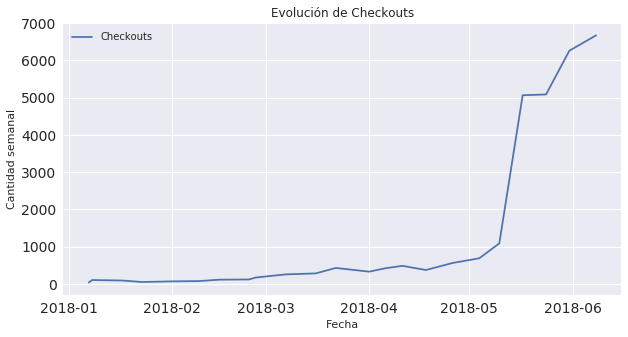

In [10]:
checkouts_by_day = df.loc[df['event'] == 'checkout',["timestamp"]]
checkouts_by_day["Fecha"] = checkouts_by_day["timestamp"].dt.date
checkouts_by_day["Semana"] = checkouts_by_day["timestamp"].dt.week
checkouts_by_day.drop("timestamp", axis=1, inplace= True)
checkouts_by_day["Checkouts"] = 1

checkouts_by_week = checkouts_by_day.groupby(by="Semana").agg({"Fecha": "first", "Checkouts": "count"})
checkouts_by_week = checkouts_by_week.iloc[0:-1] # elimino la ultima semana porque quedo con menos de 7 dias
checkouts_by_day = checkouts_by_day.groupby(by="Fecha")['Checkouts'].agg("count")

ax = checkouts_by_week.set_index('Fecha').plot(figsize=(10,5)\
    ,fontsize=14,title='Evolución de Checkouts')
ax.set(xlabel='Fecha', ylabel='Cantidad semanal')

Aparentemente, algo ocurrió a mitad de Mayo. Haciendo zoom podemos ver que el 14 comenzaron a aumentar los checkouts.

Text(0.5,1,'Checkouts del 11 al 18 de Mayo')

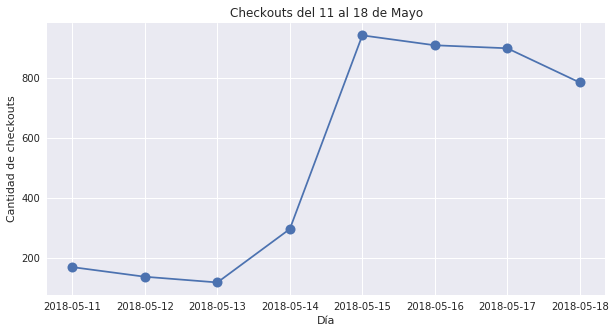

In [11]:
acotado = checkouts_by_day.loc[pd.to_datetime("2018-05-11").date() : pd.to_datetime("2018-05-18").date()]

ax = acotado.plot(marker=".",markersize="20",figsize=(10,5))
ax.set(xlabel='Día', ylabel='Cantidad de checkouts')
ax.set_title('Checkouts del 11 al 18 de Mayo')

Ahora analicemos la evolución de las conversiones.

Text(0.5,1,'Evolución de Conversiones')

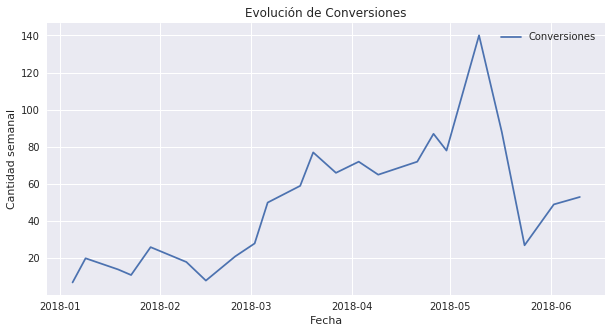

In [12]:
conversiones_by_week = df.loc[df['event'] == 'conversion',["timestamp"]]
conversiones_by_week["Fecha"] = conversiones_by_week["timestamp"].dt.date
conversiones_by_week["Semana"] = conversiones_by_week["timestamp"].dt.week
conversiones_by_week.drop("timestamp", axis=1, inplace= True)
conversiones_by_week["Conversiones"] = 1
conversiones_by_week = conversiones_by_week.groupby(by="Semana").agg({"Fecha": "first", "Conversiones": "count"})#.set_index('Fecha')
conversiones_by_week = conversiones_by_week.iloc[0:-1]

p = conversiones_by_week.set_index('Fecha').plot(figsize=(10,5))
p.set(ylabel='Cantidad semanal')
p.set_title('Evolución de Conversiones')

Veamos si hay correlación entre el aumento de checkouts y las conversiones.

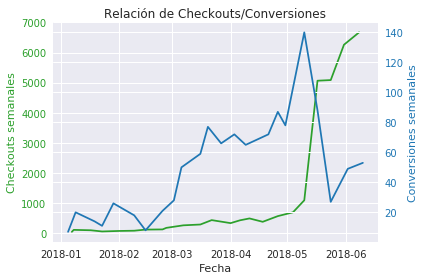

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Checkouts semanales', color=color)
ax1.plot(checkouts_by_week.set_index('Fecha'), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Conversiones semanales', color=color)
ax2.plot(conversiones_by_week.set_index('Fecha'), color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Relación de Checkouts/Conversiones')

fig.tight_layout()
plt.show()

Se observa un aumento significativo tanto de conversiones como de checkouts en la segunda semana de mayo, pero de ahi en adelante solo los checkouts siguieron aumentando mientras que las conversiones disminuyeron. Analizaremos la proporcion de conversiones sobre checkouts hasta esa semana.


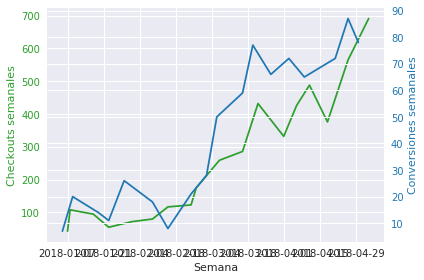

In [14]:
checkouts_hasta_mayo = checkouts_by_week.loc[0:18].set_index('Fecha')
conversiones_hasta_mayo = conversiones_by_week.loc[0:18].set_index('Fecha')

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Checkouts semanales', color=color)
ax1.plot(checkouts_hasta_mayo, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Conversiones semanales', color=color)
ax2.plot(conversiones_hasta_mayo, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

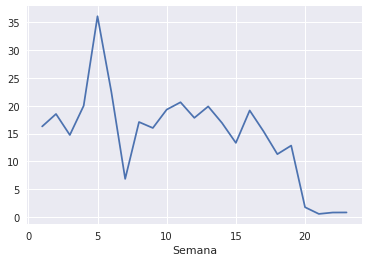

In [15]:
porcentaje_conversiones_sobre_checkouts = (conversiones_by_week['Conversiones'] / checkouts_by_week['Checkouts']) * 100
ax = porcentaje_conversiones_sobre_checkouts.plot()


Vemos que hasta mayo la cantidad de checkouts y conversiones estaban intimamente relacionadas, representando alrededor de un 15% la cantidad de conversiones sobre la cantidad de checkouts. Debemos analizar que sucede en mayo que hace que de ahi en adelante suban los checkouts pero bajen las conversiones.

### CELULARES

Text(0,0.5,'Cantidad')

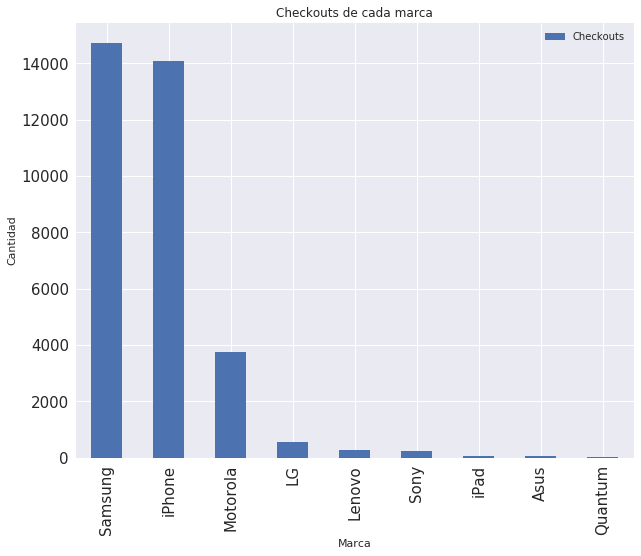

In [16]:
def obtener_marca(serie_de_modelo):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(modelo.split()[0])
    return r

checkouts["Marca"] = obtener_marca(checkouts["model"])
checkouts = checkouts.loc[checkouts["Marca"] != "Unknown"] # Remuevo datos erroneos
checkouts["Checkouts"] = 1
checkouts_by_marca = checkouts[["Marca","Checkouts"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Checkouts",ascending=False)
checkouts_by_marca.plot(kind="bar",figsize=(10,8),fontsize=15,title="Checkouts de cada marca").set_ylabel("Cantidad")

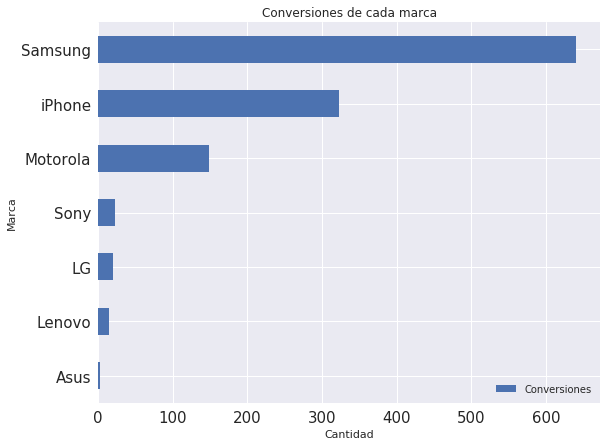

In [17]:
conversiones["Marca"] = obtener_marca(conversiones["model"])
conversiones = conversiones.loc[conversiones["Marca"] != "Unknown"] # Remuevo datos erroneos
conversiones["Conversiones"] = 1
conversiones_by_marca = conversiones[["Marca","Conversiones"]].groupby(by=["Marca"]).agg("count")\
    .sort_values(by="Conversiones",ascending=False).iloc[::-1]
p = conversiones_by_marca.plot(kind="barh",figsize=(9,7),fontsize=15,title="Conversiones de cada marca")
p.set_xlabel("Cantidad")
p.legend(loc="lower right")
p

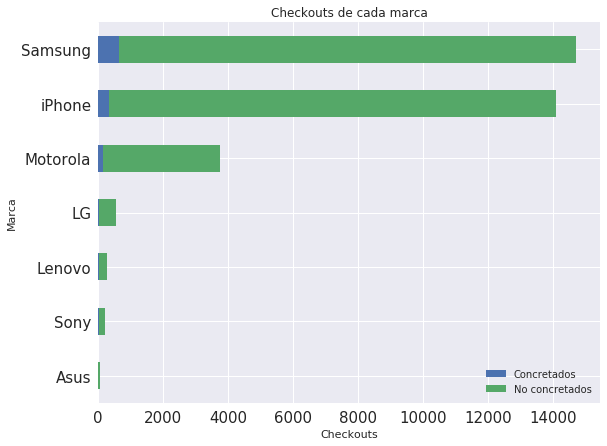

In [18]:
marca_stats = conversiones_by_marca.join(checkouts_by_marca).sort_values(by="Checkouts",ascending=False)
marca_stats["No concretados"] = marca_stats["Checkouts"] - marca_stats["Conversiones"]
marca_stats = marca_stats.rename(columns={'Conversiones': 'Concretados'}).iloc[::-1]
marca_stats.drop("Checkouts", axis=1, inplace= True)
p = marca_stats.plot(kind="barh",stacked=True,figsize=(9,7),fontsize=15,\
                 title="Checkouts de cada marca")
p.legend(loc="lower right")
p.set_xlabel("Checkouts")
p

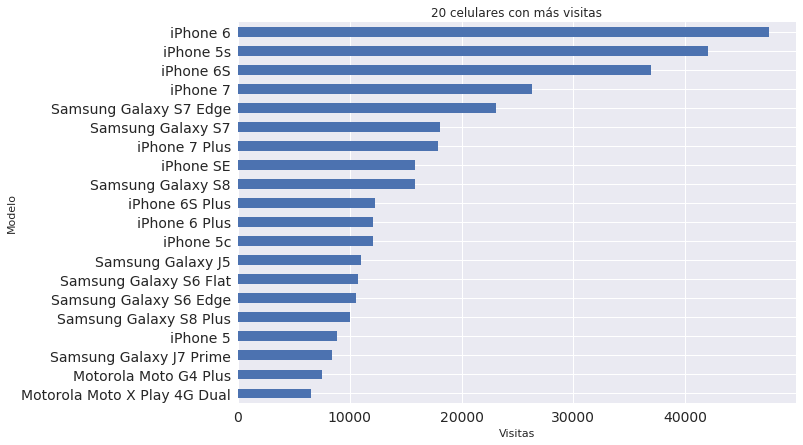

In [19]:
view_products = df.loc[df["event"] == "viewed product",["model"]].copy()
view_products["Marca"] = obtener_marca(view_products["model"])
view_products["Visitas"] = 1
p = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(20)\
    .iloc[::-1].plot(kind="barh",title="20 celulares con más visitas",figsize=(10,7),fontsize=14,legend=False)
p.set_ylabel("Modelo")
p.set_xlabel("Visitas")
p

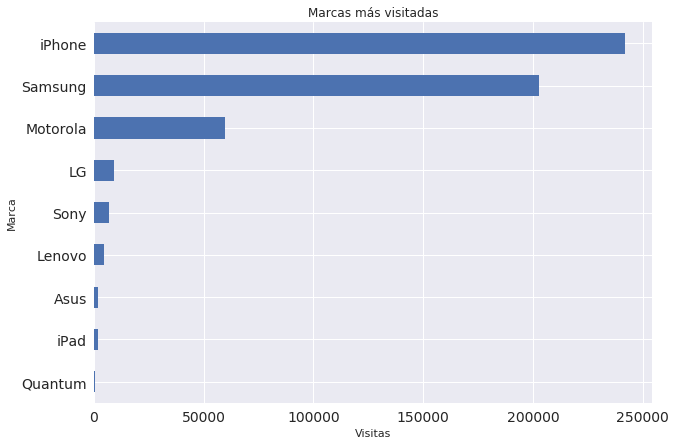

In [20]:
view_products_by_marca = view_products.drop(columns=["model"]).groupby(by="Marca").agg("sum")

p = view_products_by_marca.sort_values(by="Visitas",ascending=False)\
    .iloc[::-1].plot(kind="barh",title="Marcas más visitadas",figsize=(10,7),fontsize=14,legend=False)
p.set_xlabel("Visitas")
p

In [74]:
marca_stats = view_products_by_marca.join(checkouts_by_marca,on="Marca",how="outer")\
    .join(conversiones_by_marca,on="Marca",how="outer")
marca_stats['Visitas']= (marca_stats['Visitas']/marca_stats['Visitas'].sum()) *100
marca_stats['Checkouts']= (marca_stats['Checkouts']/marca_stats['Checkouts'].sum()) *100
marca_stats['Conversiones']= (marca_stats['Conversiones']/marca_stats['Conversiones'].sum()) * 100
marca_stats = marca_stats.fillna(0)
marca_stats = marca_stats.T

In [75]:
#import plotly.plotly as py
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

data = [go.Scatterpolar(
  r = marca_stats["Samsung"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'Samsung',
  fill = 'toself'
),go.Scatterpolar(
  r = marca_stats["iPhone"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'iPhone',
  fill = 'toself'
),go.Scatterpolar(
  r = marca_stats["Motorola"].tolist(),
  theta = ['Visitas','Checkouts','Conversiones'],
    name = 'Motorola',
    fill = 'toself'
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 60]
    )
  ),
    title='Porcentaje de visitas, checkouts, y conversiones de marcas',
    font= dict(
        size =18
    ),
  showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [64]:
#analizar
pd.crosstab(checkouts['condition'],checkouts['Marca']) # hacerlo en el otro notebook

Marca,Asus,LG,Lenovo,Motorola,Quantum,Samsung,Sony,iPad,iPhone
condition,,,,,,,,,
Bom,9,183,89,1633,7,8141,81,5,5157
Excelente,13,164,96,1035,7,3611,75,46,4094
Muito Bom,41,215,87,1070,5,2940,62,21,3743
Bom - Sem Touch ID,0,0,0,0,0,2,0,0,1088
Novo,0,0,0,0,0,13,0,0,0


In [ ]:






#### Analsis de checkouts por persona

primer_evento_por_persona = df.loc[df['new_vs_returning']=='New',['timestamp','person']].set_index('person')


Veo si existen casos de double tracking

def min_diferencia_tiempo(df):
        min_diferencia=pd.to_timedelta('365 days')
        for i in range(1,len(df)):
            dif = df.iloc[i]-df.iloc[i-1]
            if dif<min_diferencia:
                min_diferencia = dif
        return min_diferencia    
            
checkouts_por_persona = df.loc[df['event']=='checkout',['timestamp','person','model', 'sku']]
duplicados = checkouts_por_persona[checkouts_por_persona.duplicated(subset=['person'], keep=False)]
min_diferencia_checkouts = duplicados.groupby('person').agg({'timestamp':min_diferencia_tiempo}).sort_values(by='timestamp')
min_diferencia_checkouts['menos_de_1seg'] = min_diferencia_checkouts['timestamp']<pd.to_timedelta('00:00:01')
min_diferencia_checkouts['menos_de_1seg'].value_counts()

Existe solo 1 caso de todos los checkouts que podría ser de double tracking, lo examino

min_diferencia_checkouts.loc[min_diferencia_checkouts['menos_de_1seg']==True]

checkouts_por_persona.loc[checkouts_por_persona['person']=='0ee73fbe']

Los dos eventos de checkout que son en el mismo momento son de modelos distintos, por lo tanto supondremos que no es un caso de double tracking

### Analizo la cantidad de checkouts por persona 

checkouts_por_persona['checkouts'] = 1
cantidad_de_checkouts_por_persona = checkouts_por_persona.groupby('person').agg({'checkouts':sum, 'sku':sum})
g = cantidad_de_checkouts_por_persona['checkouts'].value_counts().plot('bar')
g.set_title('Cantidad de checkouts por persona')
g.set_xlabel('Cantidad de checkouts')
g.set_ylabel('Numero de personas')

cant_checkouts_log=cantidad_de_checkouts_por_persona['checkouts'].value_counts().transform(lambda x: np.log(x)+1 )
g_log = cant_checkouts_log.plot('bar')
g_log.set_title('Cantidad de checkouts por persona [Log]')
g_log.set_xlabel('Cantidad de checkouts')
g_log.set_ylabel('Cantidad de personas')

#### Verifico si los distintos checkouts son sobre los mismos modelos

def contar_distintos(lista):
    distintos = []
    for modelo in lista:
        if modelo not in distintos:
            distintos.append(modelo)
    return len(distintos)        
multiples = cantidad_de_checkouts_por_persona.loc[cantidad_de_checkouts_por_persona['checkouts']>1]
multiples['distintos'] = multiples['sku'].apply(lambda x: contar_distintos(x.split('.0')))
#Falta!!


